# Import packages

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import time
from utils import A_cluster
from tqdm.auto import tqdm
from torchvision import transforms, datasets

# Configuration

In [2]:
class config:
    input = 28*28
    output = 10
    hid = 256    # RC Neurons
    thr = 0.5
    decay = 0.5
    rst = 0.05
    
    N_hid = hid
    p_in = 0.2        # ratio of inhibitory neurons
    gamma = 1.0       # shape factor of gamma distribution
    binary = True    # binary matrix of reservoir A
    net_type = 'BAC'  # type of reservoir connection topology
                      # 'ER',  # Erdos-Renyi Random Network
                      # 'ERC', # Clusters of Erdos-Renyi Networks
                      # 'BA',  # Barabasi-Albert Network
                      # 'BAC', # Clusters of Barabasi-Albert networks
                      # 'WS',  # Watts Strogatz small world networks
                      # 'WSC', # Clusters of Watts Strogatz small world networks
                      # 'RAN', # random network
                      # 'DTW', # Developmental Time Window for multi-cluster small-world network
    noise = True      # add noise in A
    noise_str = 0.05  # noise strength
    p_ER = 0.2        # connection probability when creating edges, for ER and WS graphs
    m_BA = 3          # number of edges to attach from a new node to existing nodes
    k = 5             # number of clusters in A
    R = 0.2           # distance factor when deciding connections in random network
    scale = False     # rescale matrix A with spectral radius
    
    
    num_minibatch = 10000
    num_per_label_minibatch = 20 # number of samples of each label in one mini-batch
    batch = 128
    epoch = 10
    lr = 0.001
    device = torch.device('cuda:0')
    

# Load datasets

In [3]:
from spikingjelly.datasets.shd import SpikingHeidelbergDigits
from spikingjelly.datasets.n_mnist import NMNIST

nmnist_train = NMNIST('D:\Ph.D\Research\SNN-SRT数据/N-MNIST', train=True, data_type='frame', frames_number=20, split_by='number')
nmnist_test = NMNIST('D:\Ph.D\Research\SNN-SRT数据/N-MNIST', train=False, data_type='frame', frames_number=20, split_by='number')
train_loader = torch.utils.data.DataLoader(dataset=nmnist_train, batch_size=config.batch, shuffle=True, drop_last=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(dataset=nmnist_test, batch_size=config.batch, shuffle=False, drop_last=False, num_workers=0)

# SHD_train = SpikingHeidelbergDigits('D:\Ph.D\Research\SNN-SRT数据\SHD', train=True, data_type='frame', frames_number=20, split_by='number')
# SHD_test = SpikingHeidelbergDigits('D:\Ph.D\Research\SNN-SRT数据\SHD', train=False, data_type='frame', frames_number=20, split_by='number')
# train_loader = torch.utils.data.DataLoader(dataset=SHD_train, batch_size=config.batch, shuffle=True, drop_last=False, num_workers=0)
# test_loader = torch.utils.data.DataLoader(dataset=SHD_test, batch_size=config.batch, shuffle=False, drop_last=False, num_workers=0)


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data/', train=False, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=config.batch, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=config.batch, shuffle=False)

The directory [D:\Ph.D\Research\SNN-SRT数据/N-MNIST\frames_number_20_split_by_number] already exists.
The directory [D:\Ph.D\Research\SNN-SRT数据/N-MNIST\frames_number_20_split_by_number] already exists.


# RC Model

In [4]:
class ActFun(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return input.gt(0).float()

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        temp = abs(input - 0) < 0.5 # lens
        return grad_input * temp.float()

act_fun = ActFun.apply

def mem_update(input, mem, spk, thr, decay, rst):
    mem = rst * spk + mem * decay * (1-spk) + input
    spike = act_fun(mem - thr)
    return mem, spike

In [5]:
class RC(nn.Module):
    def __init__(self) -> None:
        super(RC, self).__init__()
        input = config.input
        hid = config.hid
        out = config.output
        self.fc_in = nn.Linear(input, hid)
        self.conv_in = nn.Sequential(
                                    nn.Conv2d(1, 16, 3),
                                    nn.ReLU(),
                                    nn.AvgPool2d(2, 2),
                                    nn.Conv2d(16, 16, 3),
                                    nn.ReLU(),
                                    nn.AvgPool2d(2, 2),
                                    nn.Flatten(),
                                    self.fc_in,
                                    )
        self.fc_in.requires_grad_ = False
        self.conv_in.requires_grad_ = False
        
        # self.A = nn.Parameter(torch.tensor(A_cluster(config)), requires_grad=False) # adjacency matrix
        self.A = nn.Linear(config.hid, config.hid, bias=False) # random initialized adjacency matrix
        nn.init.uniform_(self.A.weight, a=0, b=1)
        self.fc_out = nn.Linear(hid, out)
        
        for name, p in self.named_parameters():
            if 'conv' in name or 'fc_in' in name:
                p.requires_grad = False
        
    def forward(self, input):
        batch = input.shape[0]
        time_step = 10
        input = input.view(batch, config.input)
        # if len(input.shape)>2:
        #     batch, time_step = input.shape[0:2]
        
        hid_mem = torch.zeros(batch, time_step+1, config.hid).uniform_(0, 0.1).to('cuda')
        hid_spk = torch.zeros(batch, time_step+1, config.hid).to('cuda')
        sum_spk = torch.zeros(batch, config.hid).to('cuda')
        
        for t in range(time_step):
            x = input > torch.rand(input.size()).to('cuda')
            x = self.fc_in(x.float())
            # x = self.conv_in(x.float())
            # x = self.fc_in(input[:,t,:])
            # x = self.conv_in(input[:, t, :, :, :])
            
            # x = x @ self.A
            x = F.sigmoid(self.A(x))
            
            hid_mem_tmp, hid_spk_tmp = mem_update(x, hid_mem[:,t,:], hid_spk[:,t,:], config.thr, config.decay, config.rst)
            hid_mem[:,t+1,:] = hid_mem_tmp
            hid_spk[:,t+1,:] = hid_spk_tmp
            sum_spk += hid_spk_tmp
        
        sum_spk /= time_step
        out = self.fc_out(sum_spk)
        A_norm = torch.norm(self.A.weight, p=1)
        return out, hid_mem, hid_spk, A_norm


# Training pipeline

In [6]:
def train(model, optimizer, criterion, num_epochs, train_loader, test_loader, device):
    train_accs, test_accs = [], []
    for epoch in range(num_epochs):
        now = time.time()
        correct, total = 0, 0
        for i, (samples, labels) in enumerate(tqdm(train_loader)):
            # samples = samples.requires_grad_().to(device)
            labels = labels.long().to(device)
            optimizer.zero_grad()
            outputs, _, _, A_norm = model(samples.to(device))
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted.cpu() == labels.long().cpu()).sum()
            
            loss = criterion(outputs, labels) + 0.0001*A_norm # , torch.max(A_norm-6000, 0) 规定一个区间，
            loss.backward()
            optimizer.step()
        tr_acc = 100. * correct.numpy() / total
        ts_acc = test(model, test_loader)
        train_accs.append(tr_acc)
        test_accs.append(ts_acc)
        res_str = 'epoch: ' + str(epoch) \
                    + ' Loss: ' + str(loss.item())      \
                    + '. Tr Acc: ' + str(tr_acc)        \
                    + '. Ts Acc: ' + str(ts_acc)        \
                    + '. Time:' + str(time.time()-now)  \
                    + '. A norm:' + str(A_norm.item())
        print(res_str)
    return train_accs, test_accs

def test(model, dataloader):
    correct, total = 0, 0
    for images, labels in dataloader:
        outputs, _, _, _ = model(images.to(config.device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels.long().cpu()).sum()
    accuracy = 100. * correct.numpy() / total
    return accuracy

In [7]:
def inference(data_set, model):
    img = torch.zeros(len(data_set), 28, 28)
    for i, (d,l) in enumerate(data_set):
        img[i] = d[0]
    
    labels = np.array([d[1] for d in data_set])
    idx_per_label = [np.where(labels==i)[0] for i in range(config.output)]
    # generate mini batch
    for i in range(config.num_minibatch):
        batch_idx, batch_labels = [], []
        for j in range(config.output):
            batch_idx.extend(np.random.choice(idx_per_label[j], config.num_per_label_minibatch).tolist())
            batch_labels.extend([j]*config.num_per_label_minibatch)
        batch_data = img[batch_idx]
        batch_labels = torch.tensor(batch_labels)
        
        # print(i, batch_data.shape, batch_labels)
        out, hid_mem, hid_spk = model(batch_data.to('cuda'))
        _, predicted = torch.max(out.data, 1)
        acc = (predicted.cpu() == batch_labels.long().cpu()).sum()/config.num_per_label_minibatch/config.output
        print(hid_mem.shape, hid_spk.shape, acc)

# inference(test_dataset, model)

In [8]:
model = RC().to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=config.lr)
acc = train(model, optimizer, criterion, config.epoch, train_loader, test_loader, 'cuda')
accuracy = test(model, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 0 Loss: 2.387388229370117. Tr Acc: 75.21666666666667. Ts Acc: 87.68. Time:56.35851216316223. A norm:18809.2109375


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 1 Loss: 1.2220330238342285. Tr Acc: 88.525. Ts Acc: 90.11. Time:36.00032043457031. A norm:8811.671875


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 2 Loss: 0.7201547026634216. Tr Acc: 89.52666666666667. Ts Acc: 90.36. Time:38.15273070335388. A norm:3865.57177734375


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 3 Loss: 0.6432762742042542. Tr Acc: 89.495. Ts Acc: 90.23. Time:38.77746510505676. A norm:2037.0753173828125


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 4 Loss: 0.503764808177948. Tr Acc: 89.23833333333333. Ts Acc: 89.94. Time:35.55659079551697. A norm:1366.048583984375


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 5 Loss: 0.3139323592185974. Tr Acc: 89.29. Ts Acc: 89.91. Time:36.15570664405823. A norm:1066.068359375


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 6 Loss: 0.5512634515762329. Tr Acc: 89.26333333333334. Ts Acc: 89.95. Time:35.98515319824219. A norm:899.2601318359375


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 7 Loss: 0.4345340132713318. Tr Acc: 89.41833333333334. Ts Acc: 89.36. Time:35.585608959198. A norm:798.27001953125


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 8 Loss: 0.45458608865737915. Tr Acc: 89.43333333333334. Ts Acc: 90.38. Time:35.609699010849. A norm:733.8065795898438


  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 9 Loss: 0.3928854465484619. Tr Acc: 89.53666666666666. Ts Acc: 90.29. Time:36.69402313232422. A norm:691.1226806640625


In [43]:
# 1-(model.A.weight.abs()<8.5e-3).sum()/65536
(model.A.weight==0).sum()

tensor(63461, device='cuda:0')

In [11]:
with torch.no_grad():
    baseline = 5e-3
    model.A.weight[model.A.weight <= baseline] = 0
    model.A.weight[model.A.weight > baseline] = 1.0
    print(test(model, test_loader))

78.9


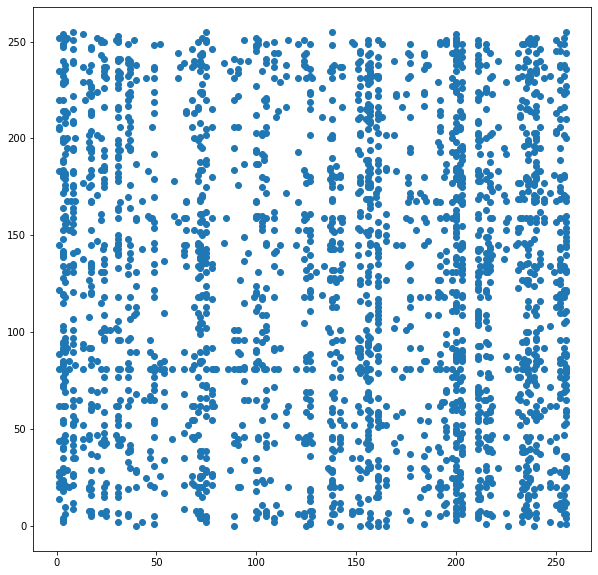

In [14]:
plt.figure(figsize=(10,10))
plt.scatter(x,y)

In [13]:
A = model.A.weight.cpu().data.numpy()
x, y = np.where(A>1e-2)
for xx, yy in zip(x,y):
    print(xx, yy)
# plt.imshow(A)

1 14
1 20
1 22
1 26
1 28
1 44
1 62
1 81
1 89
1 122
1 145
1 183
1 205
1 206
1 210
1 220
1 235
1 252
3 2
3 3
3 4
3 18
3 20
3 21
3 23
3 24
3 28
3 29
3 30
3 35
3 40
3 41
3 44
3 45
3 53
3 55
3 62
3 72
3 73
3 77
3 81
3 83
3 84
3 85
3 91
3 92
3 94
3 95
3 101
3 103
3 115
3 119
3 120
3 128
3 134
3 139
3 140
3 141
3 142
3 148
3 153
3 159
3 164
3 172
3 180
3 181
3 184
3 188
3 189
3 198
3 199
3 200
3 214
3 220
3 228
3 229
3 232
3 235
3 240
3 247
3 248
3 249
3 252
3 253
3 254
4 6
4 10
4 20
4 21
4 44
4 47
4 62
4 69
4 75
4 79
4 90
4 93
4 95
4 97
4 118
4 126
4 131
4 154
4 156
4 159
4 160
4 174
4 176
4 179
4 181
4 182
4 192
4 199
4 208
4 211
4 214
4 229
4 230
4 236
4 238
4 251
5 29
5 92
5 131
5 157
5 168
5 195
5 200
5 213
5 252
6 20
6 81
6 85
6 134
6 153
7 153
7 168
8 9
8 12
8 21
8 26
8 27
8 35
8 39
8 42
8 45
8 46
8 52
8 53
8 57
8 62
8 65
8 70
8 90
8 94
8 97
8 101
8 107
8 121
8 131
8 134
8 135
8 141
8 152
8 156
8 159
8 162
8 164
8 172
8 175
8 176
8 182
8 183
8 194
8 195
8 208
8 209
8 215
8 222
8 239
8 

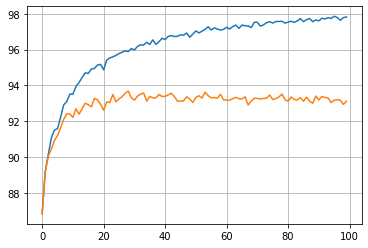

In [115]:
with open('./log/log.txt', 'r') as f:
    data = f.readlines()
test_acc = []
for d in data:
    test_acc.append(float(d.split('Ts Acc: ')[1].split('. ')[0]))
plt.plot(acc[0])
plt.plot(test_acc)
plt.grid()

In [6]:
model = RC().to('cuda')
# model.conv_in.requires_grad_ = False
for name, p in model.named_parameters():
    if 'conv' in name or 'fc_in' in name:
        p.requires_grad = False
        # print(name, p.shape)
    # if p.requires_grad is False:
    #     print(p.shape)
params = sum(param.numel() for param in model.parameters() if param.requires_grad)
print("Parameters: {:.2f}K".format(params / 1e3))

Parameters: 5.14K


In [17]:
model = RC()
non_zero, per_node = [], []
for i in range(256):
    model.A[i,:] = 0
    model.A[:,i] = 0
    # print(i, (model.A!=0).sum(), (model.A!=0).sum()/256)
    non_zero.append((model.A!=0).sum().item())
    per_node.append((model.A!=0).sum().item()/256)

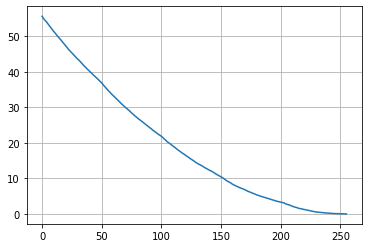

In [20]:
plt.plot(per_node)
plt.grid()

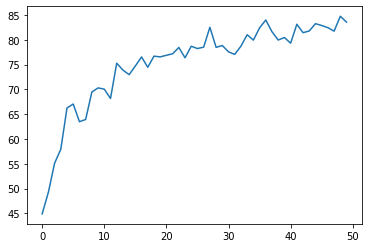

In [57]:
plt.plot(acc)

In [6]:
from thop import profile

model = RC().to('cuda')
model.conv_in.requires_grad_ = False
params = sum(param.numel() for param in model.parameters() if param.requires_grad)
print("Parameters: {:.2f}K".format(params / 1e3))

input = torch.randn(1, 20, 2, 34, 34).cuda() #.to(config.device)
flops, params = profile(model.cuda(), inputs=(input,))
print("FLOPS: {:.2f}M".format(flops / 1e6))
print("Parameters: {:.2f}K".format(params / 1e3))

Parameters: 208.72K
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register count_avgpool() for <class 'torch.nn.modules.pooling.AvgPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
FLOPS: 31.09M
Parameters: 409.68K
